In [147]:
import geopandas as gpd
import networkx as nx
import pickle
import matplotlib.pyplot as plt
from shapely.geometry import box
import geopandas as gpd
from shapely.geometry import Point

In [148]:
#takes a sec to process this:
roads = gpd.read_file("gis_osm_roads_free_1.shp")
len(roads), roads.columns

(3761287,
 Index(['osm_id', 'code', 'fclass', 'name', 'ref', 'oneway', 'maxspeed',
        'layer', 'bridge', 'tunnel', 'geometry'],
       dtype='object'))

In [149]:
roads["fclass"].value_counts().head(20)

fclass
service           1809019
residential        832390
footway            479410
secondary          146561
track              125934
tertiary            84182
primary             50718
unclassified        40541
path                32905
motorway            30948
motorway_link       25697
secondary_link      23463
cycleway            22927
trunk               17872
primary_link         9500
trunk_link           7875
tertiary_link        5498
steps                4644
track_grade5         3357
pedestrian           2213
Name: count, dtype: int64

In [150]:
roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,4342988,5111,motorway,Sam Rayburn Tollway,SRT,F,112,0,F,F,"LINESTRING (-97.001 32.99, -97.002 32.99, -97...."
1,4343083,5111,motorway,Sam Rayburn Tollway,SRT,F,112,0,F,F,"LINESTRING (-97.006 32.991, -97.006 32.991, -9..."
2,4343084,5111,motorway,Sam Rayburn Tollway,SRT,F,112,1,T,F,"LINESTRING (-96.993 32.986, -96.993 32.987, -9..."
3,4343087,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (-96.999 32.988, -96.998 32.988, -9..."
4,4343088,5131,motorway_link,None,None,F,0,0,F,F,"LINESTRING (-96.997 32.988, -96.997 32.988, -9..."


In [151]:
with open("texas_roads.pkl", "rb") as f:
    G = pickle.load(f)

G.number_of_nodes(), G.number_of_edges()


(5828743, 7024931)

In [152]:
import random

# Sample 400 nodes to visualize
sample_nodes = random.sample(list(G.nodes()), 400)
H = G.subgraph(sample_nodes).copy()

len(H.nodes()), len(H.edges())


(400, 3)

In [153]:
major_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
    "residential", "unclassified", "living_street"
]

roads_major = roads[roads["fclass"].isin(major_classes)]
len(roads_major)


1275397

## Leander

#### Maps

5633 road segments in Leander area


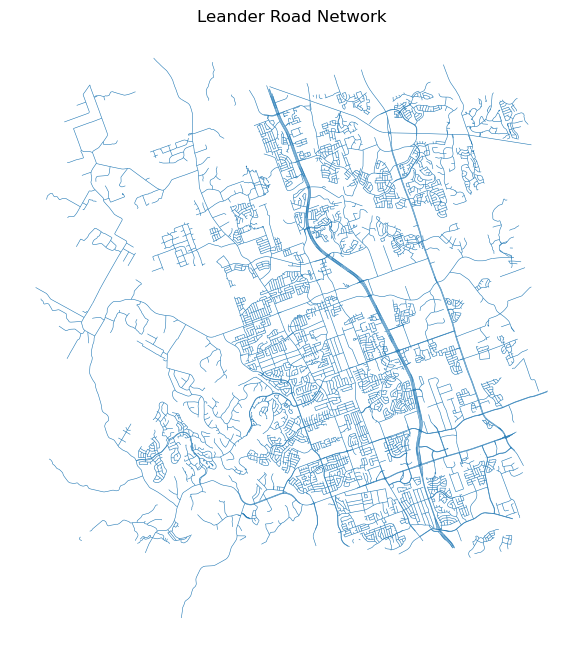

In [156]:
# Leander road network
import matplotlib.pyplot as plt

# Leander bounding box (rough but accurate)
leander_bbox = (-97.95, -97.78, 30.50, 30.65)

leander_roads = roads_major.cx[
    leander_bbox[0]:leander_bbox[1],
    leander_bbox[2]:leander_bbox[3]
]

print(len(leander_roads), "road segments in Leander area")

leander_proj = leander_roads.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))
leander_proj.plot(ax=ax, linewidth=0.4)
ax.set_title("Leander Road Network")
ax.set_axis_off()
plt.show()


5633 road segments in Leander


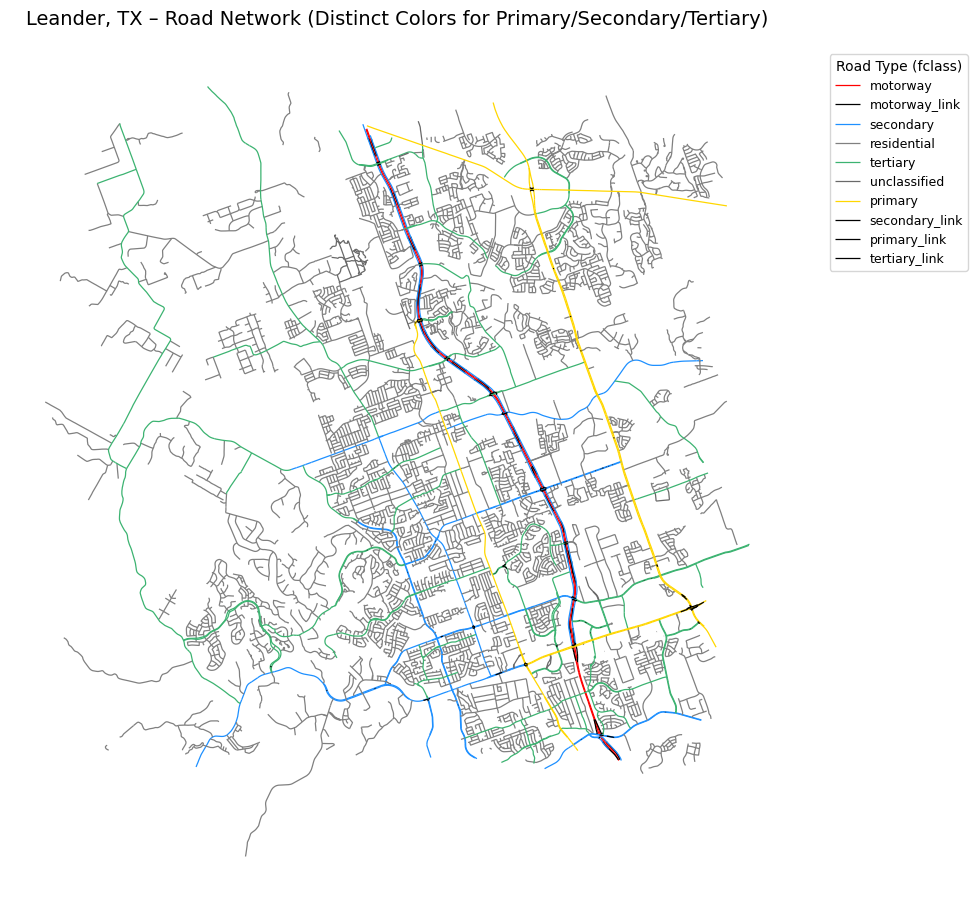

In [157]:
import matplotlib.pyplot as plt

# --- Leander bounding box ---
leander_bbox = (-97.95, -97.78, 30.50, 30.65)

# Subset road data
leander_roads = roads_major.cx[
    leander_bbox[0]:leander_bbox[1],
    leander_bbox[2]:leander_bbox[3]
]

print(len(leander_roads), "road segments in Leander")

# Project
leander_proj = leander_roads.to_crs(epsg=3857)

# CUSTOM color palette
color_map = {
    "motorway": "red",
    "trunk": "orange",
    "primary": "gold",
    "secondary": "dodgerblue",
    "tertiary": "mediumseagreen",
    
    # Minor roads
    "residential": "gray",
    "unclassified": "dimgray",
    "living_street": "lightgray",
    "service": "lightgray",
    
    # Tracks
    "track": "saddlebrown",
    "track_grade1": "saddlebrown",
    "track_grade2": "sienna",
    "track_grade3": "peru",
    "track_grade4": "tan",
    "track_grade5": "wheat",

    # Walking/bike
    "cycleway": "purple",
    "footway": "forestgreen",
    "path": "darkgreen",
    "bridleway": "darkcyan",
}

# fallback color if type not in dict
default_color = "black"

# Determine unique road classes
road_types = leander_proj["fclass"].unique()

# Plot
fig, ax = plt.subplots(figsize=(11, 11))

for rtype in road_types:
    subset = leander_proj[leander_proj["fclass"] == rtype]
    clr = color_map.get(rtype, default_color)
    subset.plot(ax=ax, color=clr, linewidth=0.9, label=rtype)

ax.set_title("Leander, TX – Road Network (Distinct Colors for Primary/Secondary/Tertiary)", fontsize=14)
ax.set_axis_off()

# Legend outside the map
ax.legend(
    title="Road Type (fclass)",
    loc="upper left",
    bbox_to_anchor=(1.05, 1),
    fontsize=9
)

plt.show()


#### Analysis

In [159]:
# 1) Load the statewide graph
with open("texas_roads.pkl", "rb") as f:
    G = pickle.load(f)

print("Statewide graph:", G.number_of_nodes(), "nodes,", G.number_of_edges(), "edges")

# 2) Define Leander in WGS84 (lat/lon) – tweak if you want tighter/looser
lea_lon_min, lea_lon_max = -97.95, -97.78
lea_lat_min, lea_lat_max = 30.50, 30.65

# 3) Make a polygon in EPSG:4326 and project to EPSG:3857
lea_poly_4326 = box(lea_lon_min, lea_lat_min, lea_lon_max, lea_lat_max)
lea_gdf_4326 = gpd.GeoDataFrame(geometry=[lea_poly_4326], crs="EPSG:4326")
lea_gdf_3857 = lea_gdf_4326.to_crs(epsg=3857)

x_min, y_min, x_max, y_max = lea_gdf_3857.geometry.iloc[0].bounds
print("Leander bbox in EPSG:3857:", x_min, x_max, y_min, y_max)

# 4) Now select nodes using the *projected* (meter) bounds
leander_nodes = [
    n for n in G.nodes
    if x_min <= n[0] <= x_max and y_min <= n[1] <= y_max
]

print("Leander node count:", len(leander_nodes))

G_leander = G.subgraph(leander_nodes).copy()
print("Leander subgraph:", G_leander.number_of_nodes(), "nodes,", G_leander.number_of_edges(), "edges")


Statewide graph: 5828743 nodes, 7024931 edges
Leander bbox in EPSG:3857: -10903744.123201147 -10884819.809766289 3567983.4559358214 3587377.9145021215
Leander node count: 33281
Leander subgraph: 33281 nodes, 42445 edges


In [160]:
# Get weakly connected components (since graph is directed)
components = list(nx.weakly_connected_components(G_leander))

print("Number of components in Leander graph:", len(components))

# Keep the largest component
largest = max(components, key=len)
G_leander_cc = G_leander.subgraph(largest).copy()

print("Largest connected component:")
print("Nodes:", G_leander_cc.number_of_nodes())
print("Edges:", G_leander_cc.number_of_edges())


Number of components in Leander graph: 11580
Largest connected component:
Nodes: 2524
Edges: 4058


In [161]:
# G_leander_cc is your cleaned main Leander network

print("Computing degree centrality...")
deg = nx.degree_centrality(G_leander_cc)

print("Top 10 degree-central intersections:")
top_deg = sorted(deg.items(), key=lambda x: x[1], reverse=True)[:10]
top_deg


Computing degree centrality...
Top 10 degree-central intersections:


[((-10886282.23618074, 3576121.933215125), 0.0031708283789139914),
 ((-10885884.06862607, 3576256.9284277502), 0.0031708283789139914),
 ((-10892603.134979166, 3573368.7459910093), 0.0031708283789139914),
 ((-10890112.194393432, 3570234.1058759363), 0.0031708283789139914),
 ((-10889280.337234579, 3572507.5052821506), 0.0031708283789139914),
 ((-10888669.783223426, 3569706.887771231), 0.0031708283789139914),
 ((-10889565.971916007, 3576169.0171876857), 0.0031708283789139914),
 ((-10888462.038789708, 3568608.7826610357), 0.0031708283789139914),
 ((-10899937.074539661, 3575695.586968962), 0.0031708283789139914),
 ((-10889476.5823649, 3569320.8144614017), 0.0031708283789139914)]

In [162]:
print("Computing closeness centrality (travel-time weighted)...")

clo = nx.closeness_centrality(
    G_leander_cc,
    distance="travel_time_s"
)

top_clo = sorted(clo.items(), key=lambda x: x[1], reverse=True)[:10]
top_clo


Computing closeness centrality (travel-time weighted)...


[((-10890964.244907912, 3572229.881323438), 0.002735455305519617),
 ((-10890969.666167112, 3572244.756880099), 0.002734238498054148),
 ((-10890944.340982957, 3572175.0965191415), 0.0027307832689872353),
 ((-10890936.559750551, 3572152.4796019485), 0.002728861360315196),
 ((-10890993.377218653, 3572309.3901506714), 0.002720286038768256),
 ((-10891016.409221297, 3572227.1802033978), 0.0027136889855354303),
 ((-10891011.054753792, 3572357.467904285), 0.0027099915431656523),
 ((-10890850.776950946, 3571910.2355880896), 0.0027090428715680595),
 ((-10890907.761398284, 3572187.6456947713), 0.002707908647126848),
 ((-10891090.325363185, 3572187.955870228), 0.0027065330276743404)]

In [163]:
print("Computing betweenness centrality (sampled)...")

btw = nx.betweenness_centrality(
    G_leander_cc,
    k=min(500, G_leander_cc.number_of_nodes()),
    weight="travel_time_s",
    seed=42
)

top_btw = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:10]
top_btw


Computing betweenness centrality (sampled)...


[((-10891962.279802619, 3575475.406182961), 0.1791776367961935),
 ((-10890397.962658245, 3570644.540092993), 0.17455749405233942),
 ((-10890969.666167112, 3572244.756880099), 0.1737890563045202),
 ((-10890391.840086251, 3570668.601604595), 0.1734448850118953),
 ((-10890381.95491547, 3570648.869094096), 0.16049484536082476),
 ((-10890964.244907912, 3572229.881323438), 0.15821887390959555),
 ((-10891499.402227951, 3570291.143567113), 0.154137192704203),
 ((-10892049.621075096, 3571840.809708309), 0.14871451229183189),
 ((-10891451.512583012, 3573519.3253962495), 0.13148057097541635),
 ((-10891540.824210474, 3573754.1294711637), 0.13118398096748612)]

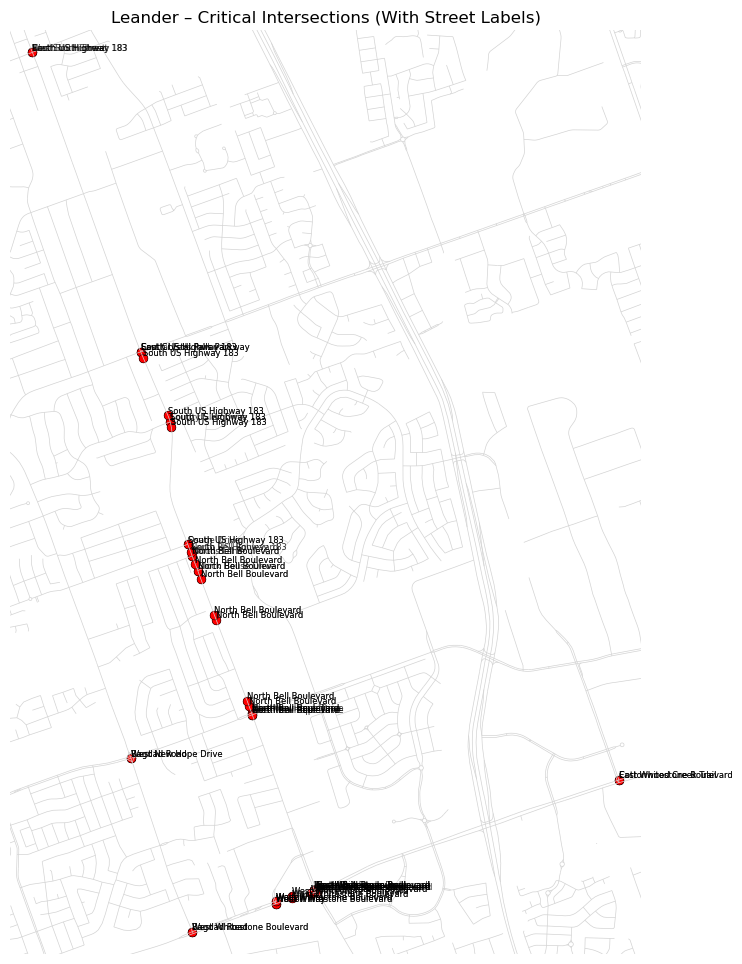

In [164]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

# --- 1) Ensure roads are in EPSG:3857 ---
roads_3857 = roads_major.to_crs(epsg=3857)

# --- 2) Spatial join: match each critical node to the road segment it touches ---
# how='nearest' will find the closest road; max_distance prevents mismatches
gdf_nodes_with_names = gpd.sjoin_nearest(
    gdf_nodes, 
    roads_3857[["name", "geometry"]],
    how="left",
    distance_col="dist",
    max_distance=5  # meters — endpoints are usually exact
)

# If a node has no road name (e.g., unnamed residential segments), fill with “Unnamed”
gdf_nodes_with_names["name"] = gdf_nodes_with_names["name"].fillna("Unnamed road")


# --- 3) Plot the base map + labels ---
fig, ax = plt.subplots(figsize=(12, 12))

# Base roads
leander_proj.plot(ax=ax, color="lightgray", linewidth=0.5)

# Critical intersections (points)
gdf_nodes_with_names.plot(
    ax=ax,
    markersize=40,
    color="red",
    edgecolor="black",
    linewidth=0.3
)

# --- 4) Add text labels for each node ---
for idx, row in gdf_nodes_with_names.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row["name"]
    ax.text(
        x, y,
        label,
        fontsize=6,
        ha='left',
        va='bottom',
        color='black',
        alpha=0.8
    )

# Zoom to the critical region
minx, miny, maxx, maxy = gdf_nodes.total_bounds
ax.set_xlim(minx - 200, maxx + 200)
ax.set_ylim(miny - 200, maxy + 200)

ax.set_title("Leander – Critical Intersections (With Street Labels)")
ax.set_axis_off()

plt.show()


In [165]:
nodes_df = pd.DataFrame(list(G_leander_cc.nodes()), columns=["x", "y"])

def test_snap(threshold):
    snap = threshold
    df = nodes_df.copy()
    df["x_snap"] = (df["x"] / snap).round() * snap
    df["y_snap"] = (df["y"] / snap).round() * snap
    unique = df[["x_snap", "y_snap"]].drop_duplicates().shape[0]
    merged = len(nodes_df) - unique
    print(f"Snap = {snap} meters → Unique: {unique}, Merged: {merged}")

# Try a range of thresholds
for t in [2, 5, 10, 15, 20, 25, 30]:
    test_snap(t)


Snap = 2 meters → Unique: 2524, Merged: 0
Snap = 5 meters → Unique: 2524, Merged: 0
Snap = 10 meters → Unique: 2518, Merged: 6
Snap = 15 meters → Unique: 2484, Merged: 40
Snap = 20 meters → Unique: 2423, Merged: 101
Snap = 25 meters → Unique: 2357, Merged: 167
Snap = 30 meters → Unique: 2326, Merged: 198


In [166]:
import networkx as nx
import pandas as pd

# Start from your largest component graph
G0 = G_leander_cc

print("Original Leander CC:", G0.number_of_nodes(), "nodes,", G0.number_of_edges(), "edges")

# 1) Build snap mapping (15 m)
snap = 15.0  # meters

nodes_df = pd.DataFrame(list(G0.nodes()), columns=["x", "y"])
nodes_df["x_snap"] = (nodes_df["x"] / snap).round() * snap
nodes_df["y_snap"] = (nodes_df["y"] / snap).round() * snap

# Map original node -> snapped node coord
mapping = {
    (row.x, row.y): (row.x_snap, row.y_snap)
    for row in nodes_df.itertuples(index=False)
}

# 2) Build new merged graph
G_leander_merged = nx.DiGraph()

for u, v, data in G0.edges(data=True):
    u2 = mapping[u]
    v2 = mapping[v]

    # Skip self-loops created by merging both ends to same snapped point
    if u2 == v2:
        continue

    # If edge already exists, keep the *shorter* travel time as representative
    if G_leander_merged.has_edge(u2, v2):
        existing_tt = G_leander_merged[u2][v2].get("travel_time_s", float("inf"))
        if data.get("travel_time_s", existing_tt) < existing_tt:
            G_leander_merged[u2][v2].update(data)
    else:
        G_leander_merged.add_edge(u2, v2, **data)

print("Merged Leander graph:", G_leander_merged.number_of_nodes(), "nodes,", G_leander_merged.number_of_edges(), "edges")


Original Leander CC: 2524 nodes, 4058 edges
Merged Leander graph: 2484 nodes, 4014 edges


In [167]:
import networkx as nx

print("Computing betweenness on merged graph...")

btw_merged = nx.betweenness_centrality(
    G_leander_merged,
    k=min(500, G_leander_merged.number_of_nodes()),
    weight="travel_time_s",
    seed=42
)

top_merged_nodes = sorted(btw_merged.items(), key=lambda x: x[1], reverse=True)[:30]
top_merged_nodes[:5]


Computing betweenness on merged graph...


[((-10890390.0, 3570675.0), 0.1809759728966394),
 ((-10891965.0, 3575475.0), 0.17999516518936343),
 ((-10890375.0, 3570645.0), 0.1783529411764706),
 ((-10890975.0, 3572250.0), 0.17680082162713825),
 ((-10890405.0, 3570645.0), 0.1719798549556809)]

In [ ]:
import geopandas as gpd
from shapely.geometry import Point

# Top N merged intersections
merged_points = [n for n, score in top_merged_nodes]

gdf_merged_nodes = gpd.GeoDataFrame(
    {"betweenness": [btw_merged[n] for n in merged_points]},
    geometry=[Point(x, y) for (x, y) in merged_points],
    crs="EPSG:3857"
)

# Roads in EPSG:3857 (if not already)
roads_3857 = roads_major.to_crs(epsg=3857)

# Spatial join: nearest road name
gdf_merged_named = gpd.sjoin_nearest(
    gdf_merged_nodes,
    roads_3857[["name", "geometry"]],
    how="left",
    distance_col="dist",
    max_distance=15  # match our snap distance
)

gdf_merged_named["name"] = gdf_merged_named["name"].fillna("Unnamed Road")


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# gdf_merged_named: critical intersections with geometry + 'name'

coords = np.vstack([gdf_merged_named.geometry.x, gdf_merged_named.geometry.y]).T

# eps is a distance in meters (try 40–60 to cluster close junctions)
db = DBSCAN(eps=50, min_samples=1).fit(coords)
gdf_merged_named["cluster"] = db.labels_

# For each cluster, keep the node with highest betweenness as the label location
gdf_clusters = (
    gdf_merged_named
    .sort_values("betweenness", ascending=False)
    .drop_duplicates(subset="cluster")
)

print("Original critical nodes:", len(gdf_merged_named))
print("Clustered label nodes:", len(gdf_clusters))

# Sort so highest-betweenness node in each cluster comes first
gdf_clusters = (
    gdf_merged_named
    .sort_values("betweenness", ascending=False)
    .drop_duplicates(subset="cluster")
)

print("Clustered label nodes:", len(gdf_clusters))

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

# Base roads
leander_proj.plot(ax=ax, color="lightgray", linewidth=0.5)

# Plot all critical nodes (faint, for reference)
gdf_merged_named.plot(
    ax=ax,
    markersize=20,
    color="red",
    alpha=0.3,
    edgecolor="none"
)

# Plot cluster representatives (bold red)
gdf_clusters.plot(
    ax=ax,
    markersize=50,
    color="red",
    edgecolor="black",
    linewidth=0.5
)

# Add labels
for idx, row in gdf_clusters.iterrows():
    x, y = row.geometry.x, row.geometry.y
    label = row["name"]
    ax.text(
        x, y,
        label,
        fontsize=7,
        ha="left",
        va="bottom",
        color="black",
        alpha=0.9,
    )

# Zoom to the area of interest
minx, miny, maxx, maxy = gdf_merged_named.total_bounds
ax.set_xlim(minx - 200, maxx + 200)
ax.set_ylim(miny - 200, maxy + 200)

ax.set_title("Leander – Critical Intersections (Clustered + Clean Labels)")
ax.set_axis_off()

plt.show()


In [ ]:
def global_efficiency(G):
    nodes = list(G.nodes())
    n = len(nodes)
    
    # Compute all-pairs shortest travel times
    dist = dict(nx.all_pairs_dijkstra_path_length(G, weight="travel_time_s"))
    
    total = 0
    count = 0
    
    for i in nodes:
        for j in nodes:
            if i != j and j in dist[i]:
                d = dist[i][j]
                if d > 0:
                    total += 1.0 / d
                    count += 1
    
    return total / count

print("Computing baseline global efficiency for Leander...")
E_before = global_efficiency(G_leander_merged)
print("Baseline global efficiency:", E_before)


In [ ]:
from shapely.geometry import Point

top_point = Point(top_node)

# Buffer ~30 meters around the intersection point
buffer_area = top_point.buffer(30)

# Find all roads that intersect this buffer
nearby = roads_3857[roads_3857.intersects(buffer_area)]

unique_streets = list(nearby["name"].dropna().unique())

print("Most critical intersection:")
print(" Coordinates:", top_node)
print(" Street names:", " & ".join(unique_streets[:4]))  # limit to 4 names
print(" Betweenness:", btw_merged[top_node])


#### Node Closures

In [173]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Make sure your roads are in EPSG:3857 to match the graph
roads_3857 = roads_major.to_crs(epsg=3857)

def get_street_names(point, roads_gdf, radius=30):
    """
    Return a combined string of all unique road names within `radius` meters
    of the given point (intersection).
    """
    buf = point.buffer(radius)
    nearby = roads_gdf[roads_gdf.intersects(buf)]
    
    names = sorted(set(nearby["name"].dropna()))
    if not names:
        return "Unnamed road"
    
    # Limit to a few names so it doesn't get crazy long
    if len(names) > 3:
        names = names[:3]
    return " & ".join(names)

def node_closure_impact_with_intersection_names(G, btw, E_base, k=10):
    """
    For the top-k nodes by betweenness:
      - compute efficiency impact of closing each node
      - attach nearest road + multi-road intersection label
    Returns a GeoDataFrame.
    """
    # 1. Pick top-k nodes by betweenness
    top_nodes = sorted(btw.items(), key=lambda x: x[1], reverse=True)[:k]
    
    results = []

    # 2. Evaluate closure impact
    for node, bscore in top_nodes:
        G_tmp = G.copy()
        if node in G_tmp:
            G_tmp.remove_node(node)
        else:
            results.append((node, bscore, None, None))
            continue

        E_after = global_efficiency(G_tmp)
        drop_pct = (E_base - E_after) / E_base * 100
        results.append((node, bscore, E_after, drop_pct))

    df = pd.DataFrame(
        results,
        columns=["node", "betweenness", "efficiency_after", "eff_drop_pct"]
    )

    # 3. Turn nodes into points
    gdf_nodes = gpd.GeoDataFrame(
        df,
        geometry=[Point(xy) for xy in df["node"]],
        crs="EPSG:3857"
    )

    # 4. Nearest single road name (optional but useful)
    joined = gpd.sjoin_nearest(
        gdf_nodes,
        roads_3857[["name", "geometry"]],
        how="left",
        distance_col="dist_nearest",
        max_distance=50
    )
    joined["road_name"] = joined["name"].fillna("Unnamed road")
    joined = joined.drop(columns=["name"])

    # 5. Multi-road intersection label
    joined["intersection_names"] = joined.geometry.apply(
        lambda p: get_street_names(p, roads_3857, radius=30)
    )

    return joined

# Run for Leander
k_nodes = 10
node_impact_intersections = node_closure_impact_with_intersection_names(
    G_leander_merged, btw_merged, E_before, k=k_nodes
)

# See the key columns
node_impact_intersections[["intersection_names", "road_name", "betweenness", "eff_drop_pct"]]


,intersection_names,road_name,betweenness,eff_drop_pct
0,East Whitestone Boulevard & North Bell Bouleva...,North Bell Boulevard,0.180976,1.707972
1,Crystal Falls Parkway & East Crystal Falls Par...,Crystal Falls Parkway,0.179995,2.513308
2,East Whitestone Boulevard & North Bell Bouleva...,North Bell Boulevard,0.178353,2.109320
3,East New Hope Drive & North Bell Boulevard & W...,North Bell Boulevard,0.176801,1.637311
4,East Whitestone Boulevard & North Bell Bouleva...,West Whitestone Boulevard,0.171980,1.488525
5,East New Hope Drive & North Bell Boulevard & W...,East New Hope Drive,0.164919,2.268417
6,Bagdad Road & West Whitestone Boulevard,Bagdad Road,0.151835,1.560491
7,East South Street & North US Highway 183 & Sou...,South US Highway 183,0.137821,1.651036
8,Block House Drive & North Bell Boulevard,North Bell Boulevard,0.137608,1.525985
9,Bagdad Road & West New Hope Drive,Bagdad Road,0.136694,0.492696


#### Edge Closures

In [ ]:
#“Which road segments are most harmful to close?”

In [181]:
print("Computing edge betweenness centrality (sampled)...")

edge_btw = nx.edge_betweenness_centrality(
    G_leander_merged,
    k=min(500, G_leander_merged.number_of_nodes()),
    weight="travel_time_s",
    seed=42
)

# Get top-k critical edges
k_edges = 10  # or adjust
top_edges = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k_edges]
top_edges[:5]


Computing edge betweenness centrality (sampled)...


[(((-10890690.0, 3570585.0), (-10890750.0, 3570555.0)), 0.02463255775343187),
 (((-10890390.0, 3570675.0), (-10890405.0, 3570660.0)), 0.024607264989691575),
 (((-10890405.0, 3570660.0), (-10890615.0, 3570615.0)), 0.024535602159094075),
 (((-10890615.0, 3570615.0), (-10890645.0, 3570600.0)), 0.024392276497899077),
 (((-10890645.0, 3570600.0), (-10890690.0, 3570585.0)), 0.02432061366730158)]

In [189]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# Make sure roads in EPSG:3857
roads_3857 = roads_major.to_crs(epsg=3857)

def edge_closure_impact_with_roadname(G, edge_btw, E_base, k=10):
    """
    For the top-k edges by edge betweenness:
      - remove each edge
      - compute new global efficiency
      - attach nearest (single) road name for interpretability
    Returns a GeoDataFrame.
    """
    results = []

    # Get top-k critical edges
    top_edges = sorted(edge_btw.items(), key=lambda x: x[1], reverse=True)[:k]

    for (u, v), bscore in top_edges:
        G_tmp = G.copy()
        if G_tmp.has_edge(u, v):
            G_tmp.remove_edge(u, v)
        else:
            results.append(((u, v), bscore, None, None, None))
            continue

        E_after = global_efficiency(G_tmp)
        drop_pct = (E_base - E_after) / E_base * 100

        # Edge midpoint
        midpoint = Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2)

        # Build a GeoDataFrame for nearest join
        gdf_mid = gpd.GeoDataFrame(
            {"betweenness": [bscore]},
            geometry=[midpoint],
            crs="EPSG:3857"
        )

        # Nearest join → EXACTLY ONE road name
        match = gpd.sjoin_nearest(
            gdf_mid,
            roads_3857[["name", "geometry"]],
            how="left",
            distance_col="dist",
            max_distance=50
        ).iloc[0]

        road_name = match["name"] if match["name"] else "Unknown road"

        results.append(((u, v), bscore, E_after, drop_pct, road_name))

    df = pd.DataFrame(
        results,
        columns=["edge", "betweenness", "efficiency_after", "eff_drop_pct", "road_name"]
    )

    # add midpoint geometry for visualization / mapping
    df_gdf = gpd.GeoDataFrame(
        df,
        geometry=[Point((u[0] + v[0]) / 2, (u[1] + v[1]) / 2) for (u, v) in df["edge"]],
        crs="EPSG:3857"
    )

    return df_gdf

# Run it
edge_impact_single_name = edge_closure_impact_with_roadname(
    G_leander_merged, edge_btw, E_before, k=k_edges
)

edge_impact_single_name[["road_name", "betweenness", "eff_drop_pct"]]

'''
You’re seeing lots of “West Whitestone Boulevard” rows because:

Each table row is a single edge (segment), not a whole road.
OSM splits a road into many segments (between curves, intersections, ramps, etc.). Every segment along West Whitestone is an edge, so you can easily get:

segment 1 of West Whitestone

segment 2 of West Whitestone

… etc.
If several of those segments are structurally important, they all show up separately.

The graph is directed, so you often have two edges per segment.
For a two-way road you built:

one edge u → v

and another v → u
edge_betweenness_centrality on a DiGraph gives a value for each direction, so you can see both directions of the same physical segment in the top-k, and they both get the same road name.

Your ranking is “top edges”, not “top roads”.
'''

,road_name,betweenness,eff_drop_pct
0,West Whitestone Boulevard,0.024633,0.904018
1,East Whitestone Boulevard,0.024607,0.946607
2,West Whitestone Boulevard,0.024536,0.910067
3,West Whitestone Boulevard,0.024392,0.906320
4,West Whitestone Boulevard,0.024321,0.905044
5,East Whitestone Boulevard,0.022745,0.897531
6,West Whitestone Boulevard,0.022634,1.015698
7,West Whitestone Boulevard,0.022562,1.017529
8,West Whitestone Boulevard,0.022491,0.470043
9,Discovery Boulevard,0.021941,2.234355


In [191]:
# edge_impact_single_name: from edge_closure_impact_with_roadname(...)
# Group by road_name and keep the *max* drop per road
road_rank = (
    edge_impact_single_name
    .groupby("road_name", as_index=False)
    .agg({
        "betweenness": "max",
        "eff_drop_pct": "max"
    })
    .sort_values("eff_drop_pct", ascending=False)
)

road_rank.head(10)


,road_name,betweenness,eff_drop_pct
0,Discovery Boulevard,0.021941,2.234355
2,West Whitestone Boulevard,0.024633,1.017529
1,East Whitestone Boulevard,0.024607,0.946607


## Austin

In [ ]:
#Austin road network
import matplotlib.pyplot as plt

# Austin bounding box (rough)
austin_bbox = (-98.05, -97.45, 30.10, 30.55)

austin_roads = roads_major.cx[
    austin_bbox[0]:austin_bbox[1],
    austin_bbox[2]:austin_bbox[3]
]

print(len(austin_roads), "road segments in Austin area")

austin_proj = austin_roads.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))
austin_proj.plot(ax=ax, linewidth=0.4)
ax.set_title("Austin Road Network")
ax.set_axis_off()
plt.show()


## Houston

In [ ]:
#Houston road network:
houston_bbox = (-95.9, -94.9, 29.4, 30.2)

houston_roads = roads_major.cx[
    houston_bbox[0]:houston_bbox[1],
    houston_bbox[2]:houston_bbox[3]
]

print(len(houston_roads), "road segments in Houston area")

houston_proj = houston_roads.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(8, 8))
houston_proj.plot(ax=ax, linewidth=0.4)
ax.set_title("Houston Road Network")
ax.set_axis_off()
plt.show()


## College Station

In [ ]:
#College Station:
# College Station bounding box (lon_min, lon_max, lat_min, lat_max)
cs_bbox = (-96.45, -96.25, 30.50, 30.70)

college_station_roads = roads_major.cx[
    cs_bbox[0]:cs_bbox[1],
    cs_bbox[2]:cs_bbox[3]
]

print(len(college_station_roads), "road segments in College Station area")

# Project for plotting
cs_proj = college_station_roads.to_crs(epsg=3857)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))
cs_proj.plot(ax=ax, linewidth=0.4)
ax.set_title("College Station Road Network")
ax.set_axis_off()
plt.show()


In [ ]:
#College Station subgraph
from build_texas_road_network import (
    geometry_to_segments,
    get_oneway_code,
    infer_speed_kph
)
import networkx as nx
import geopandas as gpd

# If you don't already have this:
major_classes = [
    "motorway", "trunk", "primary", "secondary", "tertiary",
    "unclassified", "residential", "living_street",
    "motorway_link", "trunk_link", "primary_link",
    "secondary_link", "tertiary_link",
    "service", "track"
]
roads_major = roads[roads["fclass"].isin(major_classes)]
# College Station bounding box
cs_bbox = (-96.45, -96.25, 30.50, 30.70)

cs_roads = roads_major.cx[
    cs_bbox[0]:cs_bbox[1],
    cs_bbox[2]:cs_bbox[3]
]

len(cs_roads)

# Project to metric CRS, explode multipart geometries
cs_proj = cs_roads.to_crs(epsg=3857).explode(ignore_index=True)

# Length in meters
cs_proj["length_m"] = cs_proj.geometry.length

# Speed + travel time (re-use your helper)
cs_proj["speed_kph"] = cs_proj.apply(infer_speed_kph, axis=1)
cs_proj.loc[cs_proj["speed_kph"] <= 0, "speed_kph"] = 50.0
cs_proj["travel_time_s"] = cs_proj["length_m"] / (cs_proj["speed_kph"] * 1000 / 3600)

cs_proj[[ "fclass", "length_m", "speed_kph", "travel_time_s"]].head()

G_cs = nx.DiGraph()

for idx, row in cs_proj.iterrows():
    geom = row.geometry
    road_type = row["fclass"]
    speed_kph = row["speed_kph"]
    tt_s = row["travel_time_s"]
    oneway_code = get_oneway_code(row)

    for start, end, length_m in geometry_to_segments(geom):
        sx, sy = start
        ex, ey = end
        u = (sx, sy)
        v = (ex, ey)

        # F/B: forward
        if oneway_code in ("F", "B"):
            G_cs.add_edge(
                u, v,
                length_m=length_m,
                speed_kph=speed_kph,
                travel_time_s=tt_s,
                highway=road_type
            )
        # T/B: reverse
        if oneway_code in ("T", "B"):
            G_cs.add_edge(
                v, u,
                length_m=length_m,
                speed_kph=speed_kph,
                travel_time_s=tt_s,
                highway=road_type
            )

G_cs.number_of_nodes(), G_cs.number_of_edges()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
nx.draw(
    G_cs,
    pos={n: n for n in G_cs.nodes()},  # nodes are (x, y) tuples already
    node_size=2,
    width=0.2
)
plt.title("College Station Road Network Graph")
plt.axis("equal")
plt.axis("off")
plt.show()


## Entire Texas

In [ ]:
# Nodes are stored as "(x, y)" strings from GraphML → parse into floats
pos = {}
for n in H.nodes():
    s = str(n).strip("()")
    parts = s.split(",")
    if len(parts) != 2:
        continue
    x = float(parts[0])
    y = float(parts[1])
    pos[n] = (x, y)

H_pos = H.subgraph(pos.keys()).copy()

plt.figure(figsize=(6, 6))
nx.draw(
    H_pos,
    pos=pos,
    node_size=5,
    width=0.3
)
plt.title("Tiny sample of the Texas road network graph")
plt.axis("equal")
plt.axis("off")
plt.show()


In [ ]:
#Entire Texas:
# Use the same 'roads_major' from earlier
roads_tx_proj = roads_major.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))
roads_tx_proj.plot(ax=ax, linewidth=0.15)
ax.set_title("Texas Road Network (Major Roads)")
ax.set_axis_off()
plt.show()


In [ ]:
roads_tx_sample = roads_tx_proj.sample(200000, random_state=0)  # sample 200k segments
fig, ax = plt.subplots(figsize=(10, 10))
roads_tx_sample.plot(ax=ax, linewidth=0.15)
ax.set_title("Texas Road Network (sampled major roads)")
ax.set_axis_off()
plt.show()
